**Install Libraries**

In [ ]:
!pip install tensorflow keras numpy pandas seaborn matplotlib nltk mlxtend

**Import Libraries and Load the Dataset**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Load the dataset
file_path = '/content/drive/MyDrive/SocialMediaAnalyticsProject/tweets_sentiment.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print(data.head())

       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  


**Initial Data Exploration**

In [ ]:
# Display basic information about dataset
print(data.info())
print(data.describe())

# Check for null values
print(data.isnull().sum())

# Explore the sentiment distribution
print(data['sentiment'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
None
            textID                                  text selected_text  \
count        27481                                 27480         27480   
unique       27481                                 27480         22463   
top     cb774db0d1   I`d have responded, if I were going          good   
freq             1                                     1           199   

       sentiment  
count      27481  
unique         3  
top      neutral  
freq       11118  
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
sentiment
neutral     11118
posi

**Text Preprocessing**

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove digits and special chars
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    return text

# Apply cleaning function
data['text'] = data['text'].apply(clean_text)
print(data['text'].head())


0                          id responded going
1                     sooo sad miss san diego
2                               boss bullying
3                       interview leave alone
4    sons couldnt put releases already bought
Name: text, dtype: object


**Tokenization and Sequencing**

In [ ]:
# Tokenize text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])

# Pad sequences
max_len = 50  # You can adjust this
X = pad_sequences(sequences, maxlen=max_len)

# Prepare labels
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
y = data['sentiment'].map(sentiment_mapping).values

print(X.shape, y.shape)


(27481, 50) (27481,)


**Model Building**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=max_len))  # Embedding layer
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))  # LSTM layer with dropout
model.add(Dense(64, activation='relu'))  # Dense layer for further processing
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(3, activation='softmax'))  # Output layer, '3' for three sentiment classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            320000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 357379 (1.36 MB)
Trainable params: 357379 (1.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Model Training**

In [ ]:
# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/10
344/344 [==============================] - 45s 116ms/step - loss: 0.8937 - accuracy: 0.5764 - val_loss: 0.7340 - val_accuracy: 0.6867
Epoch 2/10
344/344 [==============================] - 40s 116ms/step - loss: 0.6641 - accuracy: 0.7334 - val_loss: 0.7155 - val_accuracy: 0.6971
Epoch 3/10
344/344 [==============================] - 40s 116ms/step - loss: 0.5896 - accuracy: 0.7687 - val_loss: 0.7222 - val_accuracy: 0.7011
Epoch 4/10
344/344 [==============================] - 38s 110ms/step - loss: 0.5380 - accuracy: 0.7929 - val_loss: 0.7560 - val_accuracy: 0.7027
Epoch 5/10
344/344 [==============================] - 40s 117ms/step - loss: 0.4984 - accuracy: 0.8097 - val_loss: 0.8002 - val_accuracy: 0.7006
Epoch 6/10
344/344 [==============================] - 40s 117ms/step - loss: 0.4554 - accuracy: 0.8241 - val_loss: 0.8425 - val_accuracy: 0.6822
Epoch 7/10
344/344 [==============================] - 39s 113ms/step - loss: 0.4163 - accuracy: 0.8408 - val_loss: 0.9468 - val_ac

**Evaluate the Model**

172/172 [==============================] - 8s 44ms/step - loss: 1.2028 - accuracy: 0.6693
Accuracy on test set: 0.6692741513252258


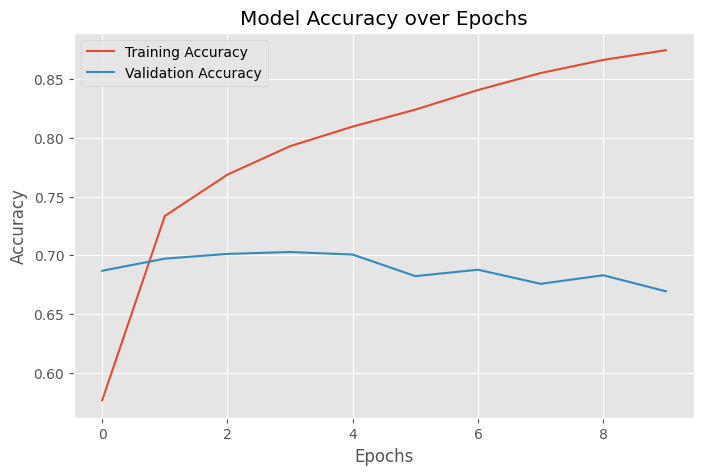

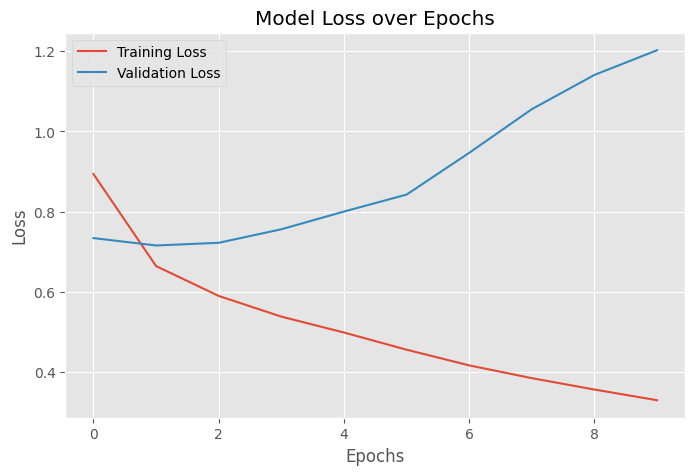

In [ ]:
# Evaluate the model on the test set
performance = model.evaluate(X_test, y_test)
print('Accuracy on test set:', performance[1])

# Plot training history
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Predict the Classes on the Test Data**

In [ ]:
# Predict classes on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

172/172 [==============================] - 2s 14ms/step


**Compute the Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

**Plot the Confusion Matrix**

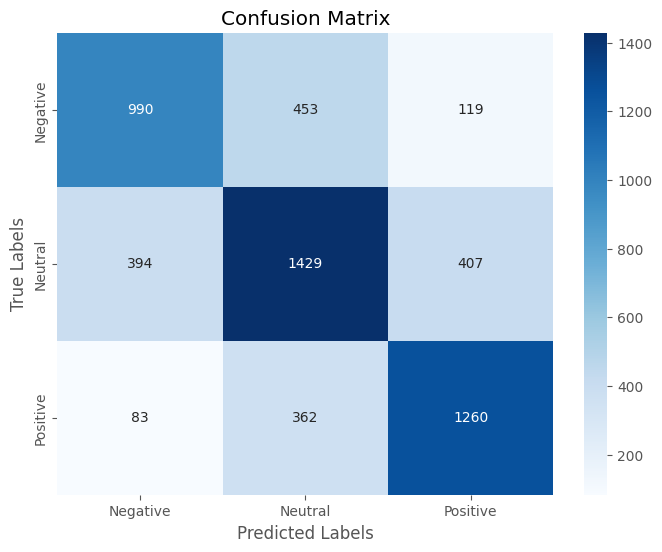

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# **Testing the sentiment analysis model**

**Prepare a Single New Text**

In [ ]:
def prepare_new_text(text):
    # Apply the same preprocessing used during training
    cleaned_text = clean_text(text)  # Assuming clean_text() is your previous cleaning function
    tokenized_text = tokenizer.texts_to_sequences([cleaned_text])  # Tokenize the text
    padded_text = pad_sequences(tokenized_text, maxlen=50)  # Pad text to the same length as training data
    return padded_text

# Example text
new_text = "I love this phone, its super fast and the camera is great!"
prepared_text = prepare_new_text(new_text)


**Predict Sentiment**

In [ ]:
def predict_sentiment(prepared_text):
    probabilities = model.predict(prepared_text)  # Get probability distribution over classes
    predicted_class = np.argmax(probabilities)  # Get the class with the highest probability
    sentiment_map = {2: "Positive", 1: "Neutral", 0: "Negative"}
    predicted_sentiment = sentiment_map[predicted_class]
    return predicted_sentiment

# Get prediction
predicted_sentiment = predict_sentiment(prepared_text)
print("Predicted Sentiment:", predicted_sentiment)


1/1 [==============================] - 0s 342ms/step
Predicted Sentiment: Positive


**Testing with Multiple Examples**

In [ ]:
new_texts = [
    "I love this phone, its super fast and the camera is great!",
    "Worst experience ever, the service was terrible!",
    "Nothing special, just an ordinary day."
]

for text in new_texts:
    prepared_text = prepare_new_text(text)
    predicted_sentiment = predict_sentiment(prepared_text)
    print(f"Text: {text}\nPredicted Sentiment: {predicted_sentiment}\n")


1/1 [==============================] - 0s 122ms/step
Text: I love this phone, its super fast and the camera is great!
Predicted Sentiment: Positive

1/1 [==============================] - 0s 162ms/step
Text: Worst experience ever, the service was terrible!
Predicted Sentiment: Negative

1/1 [==============================] - 0s 38ms/step
Text: Nothing special, just an ordinary day.
Predicted Sentiment: Neutral

